In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Tensorflowで使うGPUメモリの上限を指定
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.visible_device_list = '0' #ndivia-smiを見て判断
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10210895113149088565
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5250290773477467702
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 850676940
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16777694579533628233
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3619845411665687673
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os


from IPython.display import display, Image, display_jpeg, SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
from keras.layers import Activation, Concatenate, Dense, Dot, Dropout, Input, Reshape
from keras.layers import Multiply, Flatten, RepeatVector, Permute, Lambda
from keras.layers import Conv2D, CuDNNGRU
from keras.layers import MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam

from keras.utils import np_utils, generic_utils, plot_model
from tensorflow.python.keras.utils.vis_utils import plot_model, model_to_dot
from keras.preprocessing.image import load_img, img_to_array

In [5]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
x_train  = x_train.reshape(60000, 28, 28, 1)
x_test   = x_test.reshape(10000, 28, 28, 1)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255
y_train  = keras.utils.to_categorical(y_train, 10)
y_test   = keras.utils.to_categorical(y_test, 10)

# モデルの構築
model = Sequential()
model.add(InputLayer(input_shape=(28, 28, 1)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
____________________________________________________________

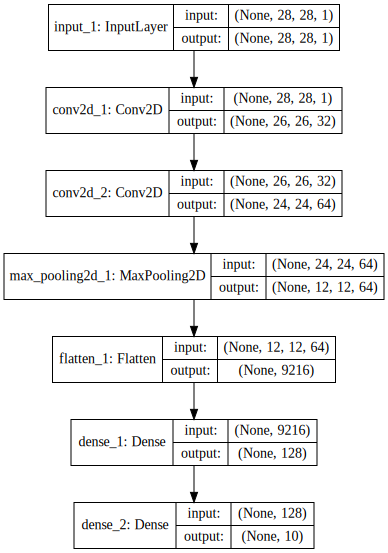

In [6]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
%%time
# 学習
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 71us/step - loss: 0.1542 - acc: 0.9523 - val_loss: 0.0459 - val_acc: 0.9861
Epoch 2/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.0423 - acc: 0.9870 - val_loss: 0.0454 - val_acc: 0.9855
Epoch 3/20
60000/60000 [==============================] - 3s 57us/step - loss: 0.0266 - acc: 0.9917 - val_loss: 0.0324 - val_acc: 0.9899
Epoch 4/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0347 - val_acc: 0.9898
Epoch 5/20
60000/60000 [==============================] - 3s 55us/step - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0306 - val_acc: 0.9906
Epoch 6/20
60000/60000 [==============================] - 3s 57us/step - loss: 0.0081 - acc: 0.9973 - val_loss: 0.0310 - val_acc: 0.9916
Epoch 7/20
60000/60000 [=========

In [8]:
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 55us/step

Test loss: 0.09576670872522856
Test accuracy: 0.9888
